In [13]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt

from multiprocessing import cpu_count
from multiprocessing import Pool

병렬 처리에 사용될 코드

In [14]:
num_cores = cpu_count()

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_cores)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [15]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [16]:
df = pd.read_csv(r'./normalized_features.csv', sep='\t', encoding='utf-8')

In [17]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [18]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
datetime          0
ID                0
HbA1c             0
Biological Sex    0
label             0
Length: 83, dtype: int64

In [19]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [20]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

### 상관관계 Matrix Heat map

In [21]:
corrdf = df.drop(columns=['datetime']).corr()

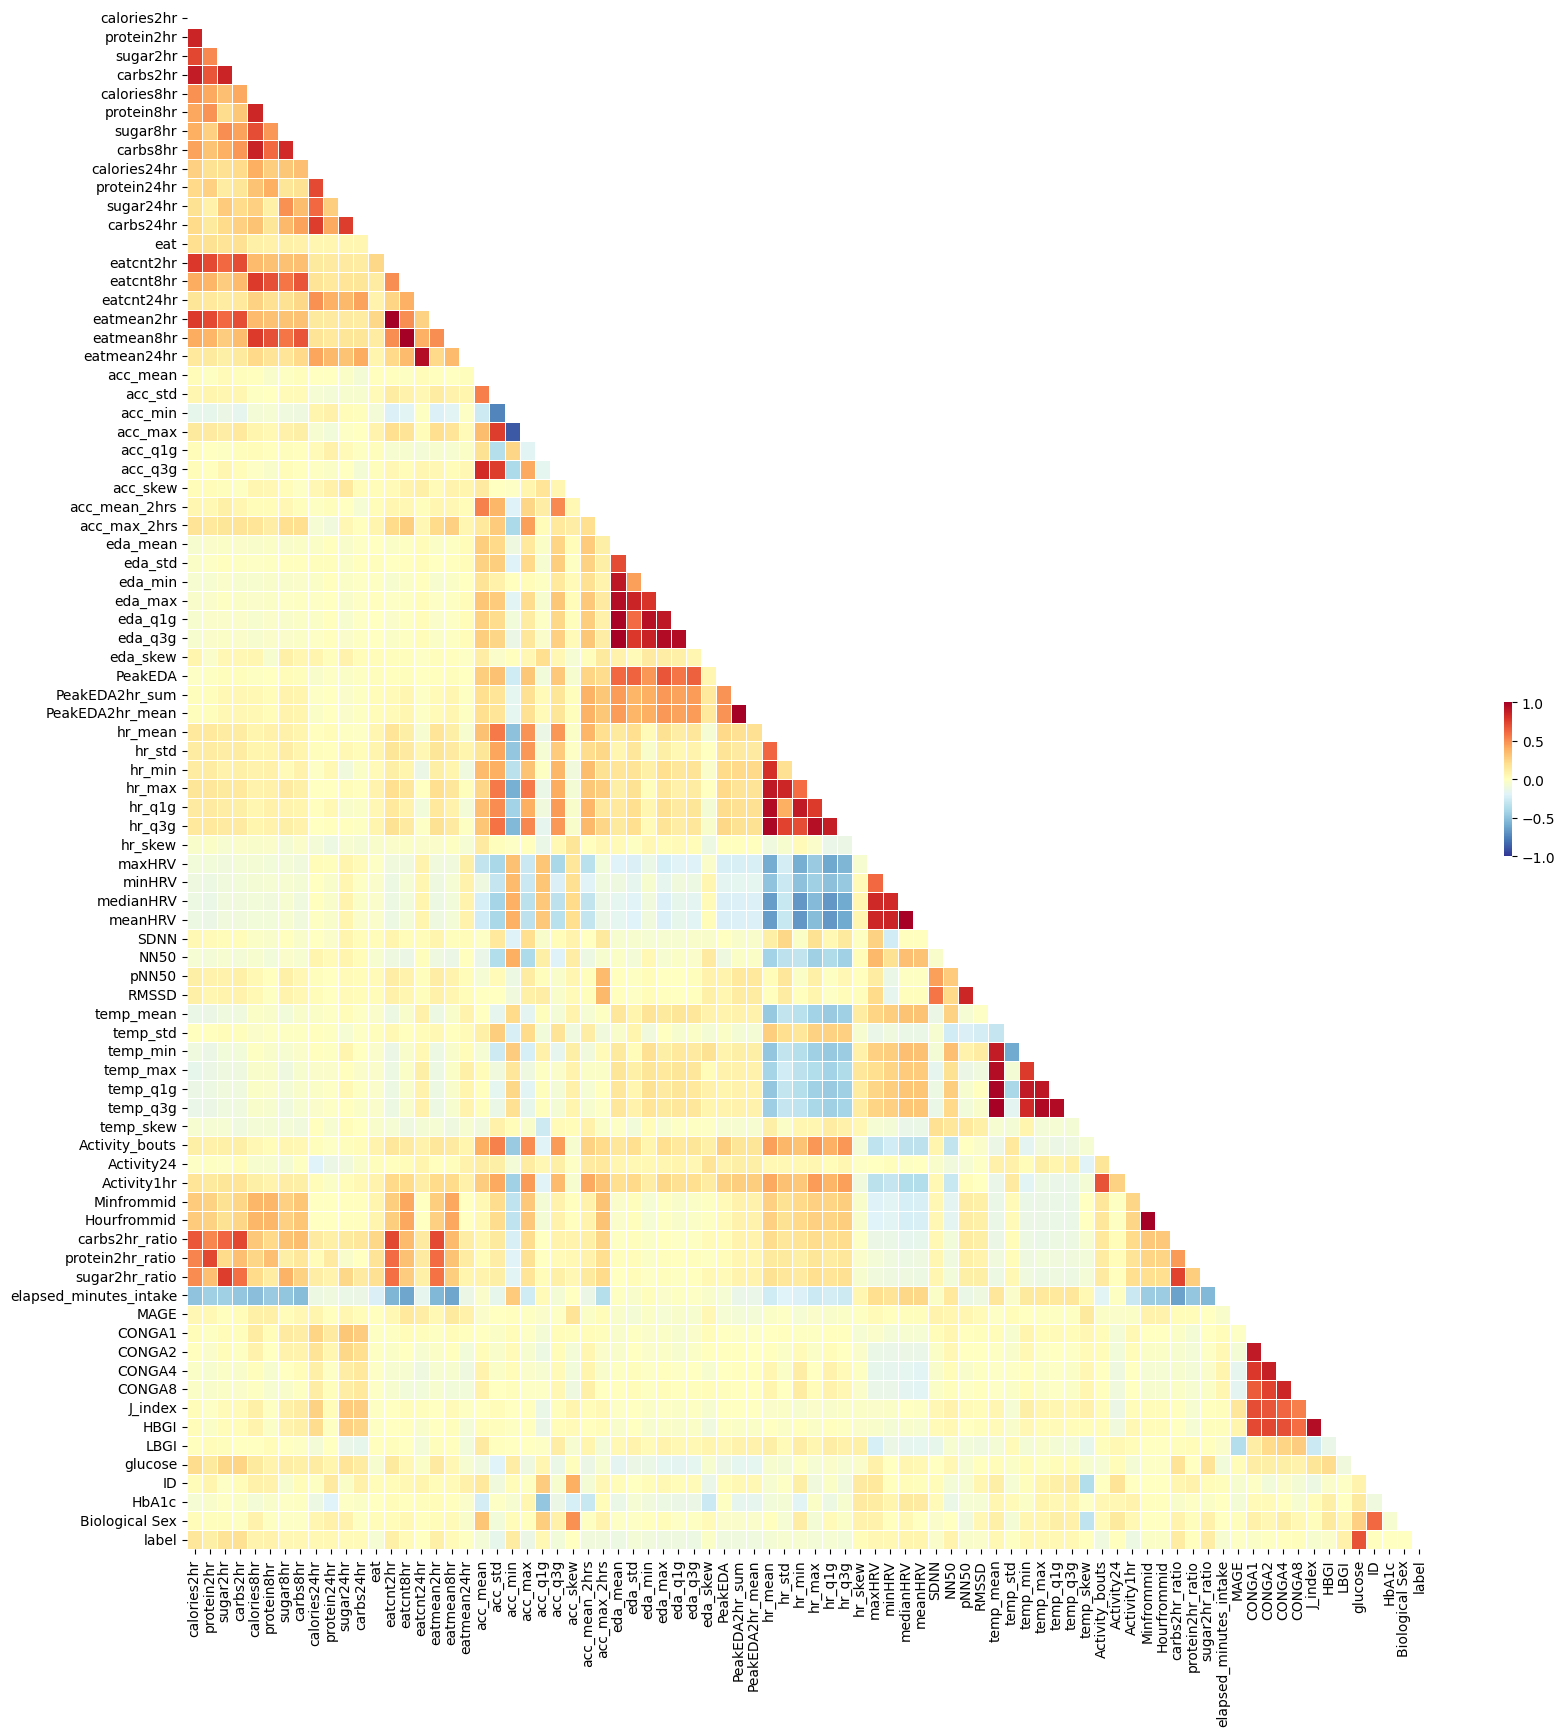

In [22]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

## 1. 독립적 교차 검증(subject-independent cross-validation), LOSO(Leave-One-Subject-Out) Model

### Leave-one-person-out cross validation Random forest regression 모델을 이용한 간질 포도당 예측에 대한 기여도 결정

In [23]:
def LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Separate data for leave-one-person-out-cross-validation (LOOCV)
    LOOCV_O = ids 
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]
    
    print(len(data_filtered))
    print(len(data_cv))
    
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor
    # Instantiate model with numestimators decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)
    # Train the model on training data
    print('Now processing... LOOCV_featureselection')
    rf.fit(X_train, y_train)
    
    # Get importances:
    importances = list(rf.feature_importances_)# List of tuples with variable and importance
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    
    return important

def RFLOOCV(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, fs=0.005):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Get important features
    listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    filteredi = listimportances[listimportances['importances'] < fs]
    filteredi = filteredi['value']
    
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
   
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)# Train the model on training data
    print('Now processing... RFLOOCV')
    rf.fit(X_train, y_train)
    
    # Use the forest's predict method on the test data
    test_predictions = rf.predict(X_test)
    train_predictions = rf.predict(X_train)
    errors = abs(test_predictions - y_test)
    
    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
    test_rmse = RMSE
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100 
    test_mape = MAPerror
    train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100 

    # List of tuples with variable and importance
    importances = list(rf.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return train_rmse, test_rmse, train_mape, test_mape, errors, RMSE, MAPerror, important

def loocvRF(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, fs=0.005):
    """
        Main loocv RF function that calls other functions to do RF feature selection, training, and testing. 

        Args:
          data (pandas DataFrame): This is a dataframe containing each participant's features and outcome variables
          idcolumn (string): This is the column name of your column containing your participant number or ID (case sensitive)
          outcomevar (string): This is the column name of your outcome variable (case sensitive)
          dropcols (list): This is a list containing strings of each column you wish to drop in your dataframe. Default is empty list [].
          numestimators (integer): The number of trees you want built in your RF. Default=1000.
          fs (float): The cutoff importance for feature selection. Anything below this importance will be removed for the RF training.
          
        Returns:
            errors (list): This is a list with the absolute error between the predicted value and actual value for each fold.
            meanrmse (float): This is the mean root mean squared error (RMSE) over all of the folds
            stdrmse (float): This is the standard deviation of the root mean squared error (RMSE) over all of the folds
            meanrmse (float): This is the mean mean average percent error (MAPE) over all of the folds
            meanrmse (float): This is the standard deviation of the mean average percent error (MAPE) over all of the folds
            importances(pandas DataFrame): This is a pandas DataFrame with 3 columns: value (feature), importances (importance of the feature), and id (fold over which this feature importance was derived)
            
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe
    errors = []
    rmse = []
    mape = []
    #eval_metrics = pd.DataFrame(columns=['rmse', 'mape', 'id'])
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    rmse_df = pd.DataFrame(columns=['train_rmse','test_rmse', 'id'])
    mape_df = pd.DataFrame(columns=['train_mape','test_mape', 'id'])
    acc_df = pd.DataFrame(columns=['train_acc','test_acc', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        train_rmse, test_rmse, train_mape, test_mape, er, rm, ma, imp= RFLOOCV(data, i, outcomevar, drop, idcolumn, numestimators, fs)
        rmse_row = pd.DataFrame({'train_rmse': [train_rmse], 'test_rmse': [test_rmse], 'id': [str(i)]})
        rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
        mape_row = pd.DataFrame({'train_mape': [train_mape], 'test_mape': [test_mape], 'id': [str(i)]})
        mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
        acc_row = pd.DataFrame({'train_acc': [100 - train_mape], 'test_acc': [100 - test_mape], 'id': [str(i)]})
        acc_df = pd.concat([acc_df, acc_row], ignore_index=True)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        #eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        #eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    
    return eval_metrics, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [24]:
#errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = loocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=1000, fs=0.02)
eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = loocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=1000, fs=0.005)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
28870
2310
Now processing... LOOCV_featureselection
LOOCV_O : 1.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_821/3877879705.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
/tmp/ipykernel_821/3877879705.py:151: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
/tmp/ipykernel_821/3877879705.py:

...1.0 processing complete.
29182
1998
Now processing... LOOCV_featureselection
LOOCV_O : 2.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...2.0 processing complete.
29155
2025
Now processing... LOOCV_featureselection
LOOCV_O : 3.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...3.0 processing complete.
29213
1967
Now processing... LOOCV_featureselection
LOOCV_O : 4.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...4.0 processing complete.
28897
2283
Now processing... LOOCV_featureselection
LOOCV_O : 5.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...5.0 processing complete.
28622
2558
Now processing... LOOCV_featureselection
LOOCV_O : 6.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...6.0 processing complete.
29184
1996
Now processing... LOOCV_featureselection
LOOCV_O : 7.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...7.0 processing complete.
28905
2275
Now processing... LOOCV_featureselection
LOOCV_O : 8.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...8.0 processing complete.
29163
2017
Now processing... LOOCV_featureselection
LOOCV_O : 9.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...9.0 processing complete.
29189
1991
Now processing... LOOCV_featureselection
LOOCV_O : 10.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...10.0 processing complete.
28613
2567
Now processing... LOOCV_featureselection
LOOCV_O : 11.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...11.0 processing complete.
29264
1916
Now processing... LOOCV_featureselection
LOOCV_O : 12.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...12.0 processing complete.
29491
1689
Now processing... LOOCV_featureselection
LOOCV_O : 13.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...13.0 processing complete.
29319
1861
Now processing... LOOCV_featureselection
LOOCV_O : 14.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...14.0 processing complete.
29453
1727
Now processing... LOOCV_featureselection
LOOCV_O : 16.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...16.0 processing complete.
Mean RMSE:22.38231085296784
Std RMSE:4.726458526300917
Mean MAPE:15.483826681739199
Std MAPE:4.4959787970512135


NameError: name 'eval_metrics' is not defined

In [ ]:
eval_df.head(20)

,rmse,mape,id
0,22.168289,19.018224,1.0
1,30.568151,18.006974,2.0
2,25.011130,18.626040,3.0
3,21.087229,15.077704,4.0
4,16.369695,13.882143,5.0
5,31.657510,15.776174,6.0
6,33.574903,33.468119,7.0
7,15.492222,9.800769,8.0
8,23.535169,13.577676,9.0
9,29.938456,22.103025,10.0


In [ ]:
print(importances)

               value  importances    id
0           sugar2hr     0.095373   1.0
1        calories8hr     0.062327   1.0
2            acc_std     0.058585   1.0
3    PeakEDA2hr_mean     0.071007   1.0
4         Activity24     0.068293   1.0
..               ...          ...   ...
193             HBGI     0.060718  16.0
194             LBGI     0.064278  16.0
195               ID     0.043308  16.0
196            HbA1c     0.062140  16.0
197   Biological Sex     0.092938  16.0

[198 rows x 3 columns]


In [ ]:
imp_err = importances.groupby('value').std(numeric_only=True).rename(columns={'importances':'std'})#.sort_values(by='importances', ascending=False)

In [ ]:
imp_err.head()

,std
value,
Activity24,0.010475
Biological Sex,0.025264
HBGI,0.011072
HbA1c,0.023606
ID,0.013314


In [ ]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                        importances       std
value                                        
Minfrommid                 0.131489  0.017247
elapsed_minutes_intake     0.088315  0.006590
HbA1c                      0.088233  0.023606
PeakEDA2hr_mean            0.079944  0.007899
HBGI                       0.079329  0.011072
Activity24                 0.078531  0.010475
sugar8hr                   0.077070  0.013229
carbs2hr                   0.074366  0.009176
acc_mean_2hrs              0.073649  0.008244
LBGI                       0.072791  0.009245
J_index                    0.070436  0.013289
acc_max_2hrs               0.070381  0.011900
acc_skew                   0.068894  0.013850
MAGE                       0.065896  0.006837
ID                         0.065746  0.013314
calories24hr               0.065354  0.008449
sugar2hr                   0.064323  0.021029
acc_std                    0.062324  0.008602
calories8hr                0.061729  0.002232
Biological Sex             0.05385

/tmp/ipykernel_3694/3888890867.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


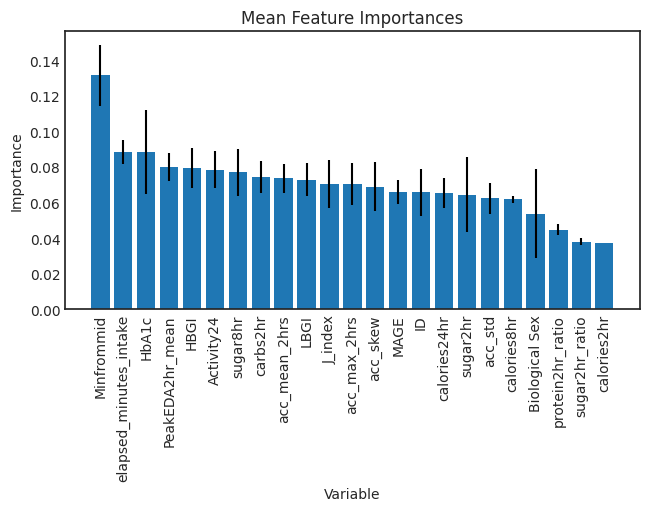

In [ ]:
plt.style.use('seaborn-white')
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical', yerr=filteredimp['std'])# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()

In [ ]:
importances[importances['id'] == '1.0'].sort_values(by='importances', ascending=False).head(30)

,value,importances,id
5,Minfrommid,0.106431,1.0
0,sugar2hr,0.095373,1.0
13,HbA1c,0.094747,1.0
8,elapsed_minutes_intake,0.087715,1.0
10,HBGI,0.082563,1.0
3,PeakEDA2hr_mean,0.071007,1.0
11,LBGI,0.070317,1.0
4,Activity24,0.068293,1.0
12,ID,0.066269,1.0
1,calories8hr,0.062327,1.0


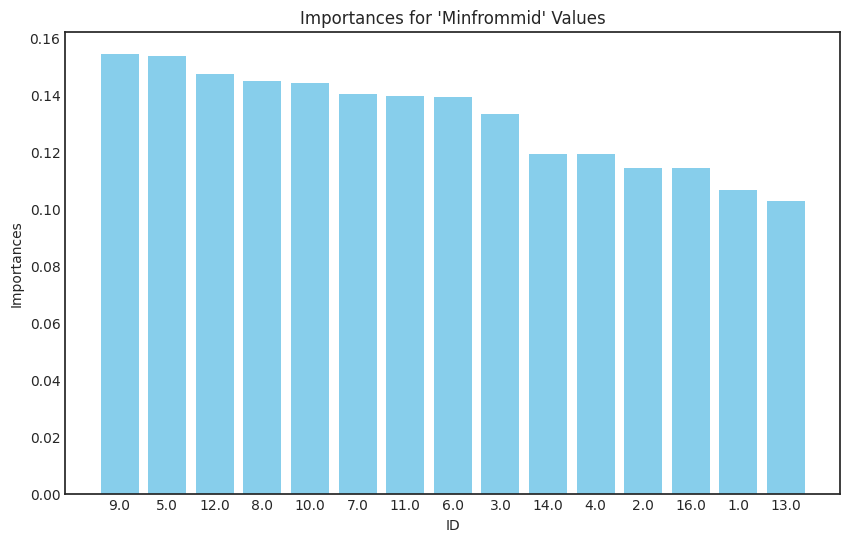

In [ ]:
# 'value'가 'Minfrommid'인 항목 필터링
filtered_df = importances[importances['value'] == 'Minfrommid'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'Minfrommid' Values")
plt.show()

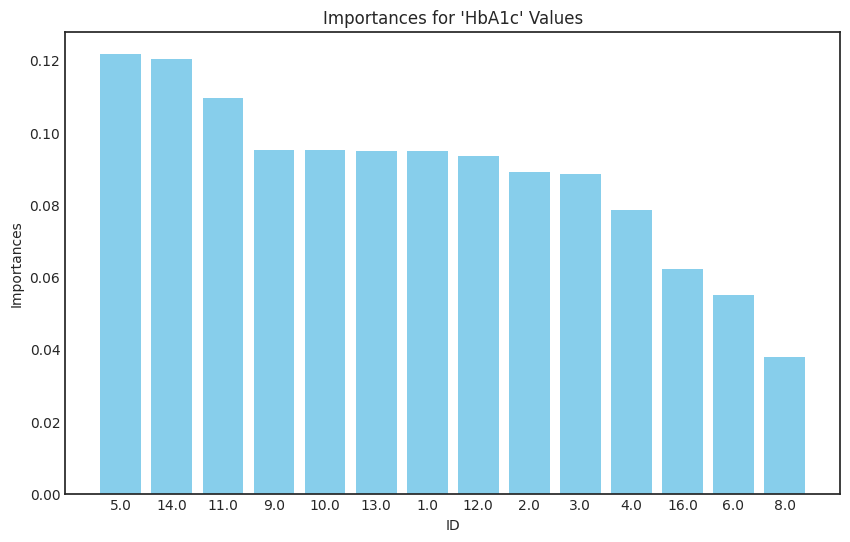

In [ ]:
filtered_df = importances[importances['value'] == 'HbA1c'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'HbA1c' Values")
plt.show()

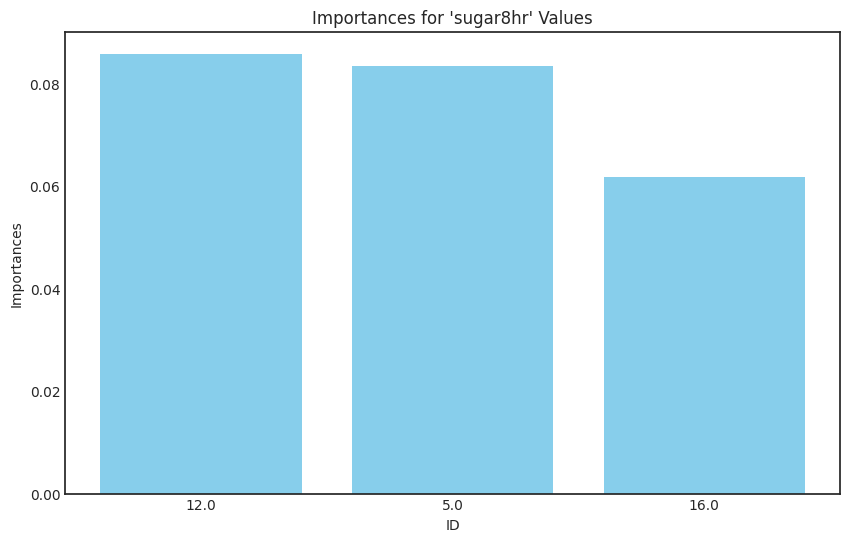

In [ ]:
filtered_df = importances[importances['value'] == 'sugar8hr'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'sugar8hr' Values")
plt.show()

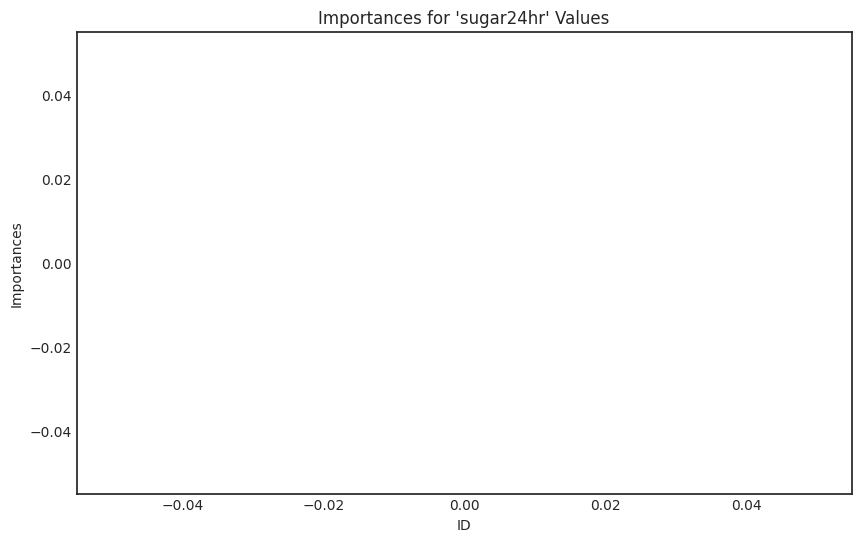

In [ ]:
filtered_df = importances[importances['value'] == 'sugar24hr'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'sugar24hr' Values")
plt.show()

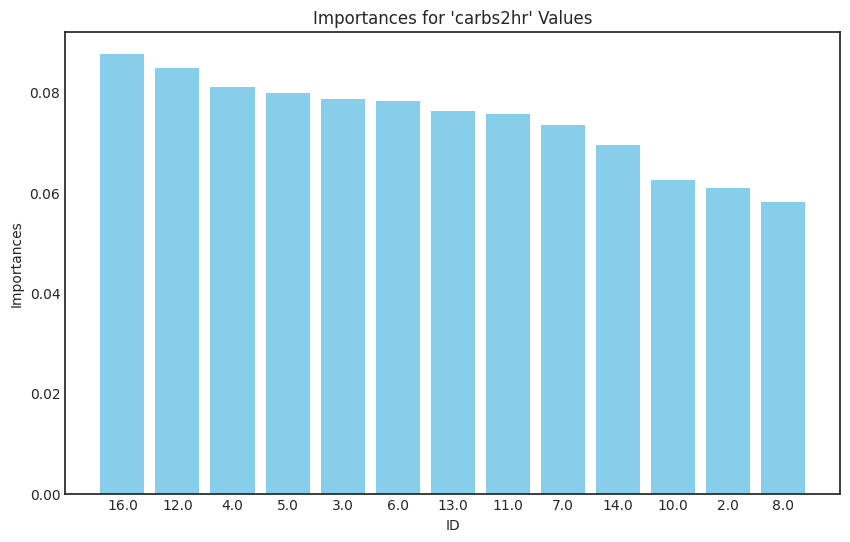

In [ ]:
filtered_df = importances[importances['value'] == 'carbs2hr'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'carbs2hr' Values")
plt.show()

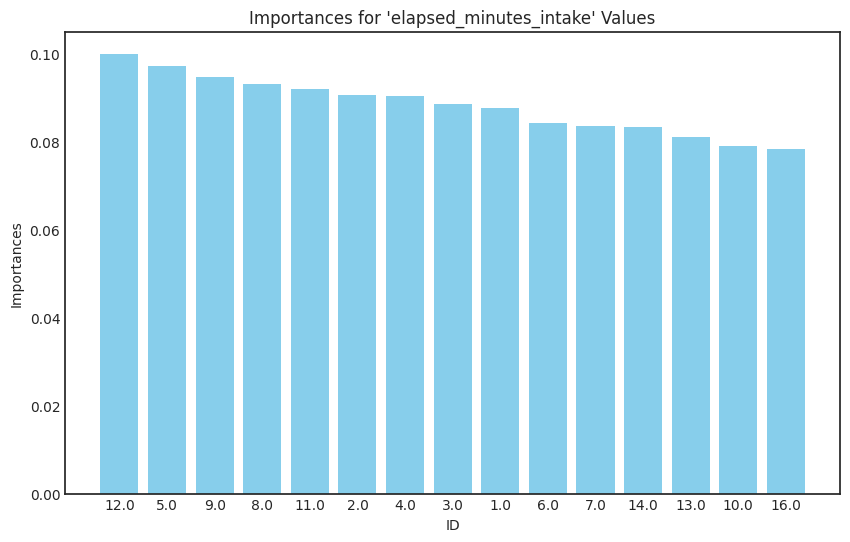

In [ ]:
filtered_df = importances[importances['value'] == 'elapsed_minutes_intake'].sort_values(by='importances', ascending=False)

# 그래프 생성
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['id'], filtered_df['importances'], color='skyblue')
plt.xlabel('ID')
plt.ylabel('Importances')
plt.title("Importances for 'elapsed_minutes_intake' Values")
plt.show()

In [ ]:
importances[importances['id'] == '7.0'].sort_values(by='importances', ascending=False)

,value,importances,id
86,Minfrommid,0.140313,7.0
92,ID,0.093029,7.0
85,Activity24,0.091693,7.0
90,HBGI,0.089571,7.0
88,elapsed_minutes_intake,0.083627,7.0
91,LBGI,0.074290,7.0
82,carbs2hr,0.073468,7.0
84,acc_mean_2hrs,0.071481,7.0
89,MAGE,0.065929,7.0
83,acc_std,0.065825,7.0


## 3. 부분 개인화 교차 검증(partial personalization cross-validation) Model

In [ ]:
from sklearn.metrics import roc_auc_score

def PartialPersonalization_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, personalization_train_percent=0.5):
    """
        Intermediate function. Please use loocvRF function.
            
    """
    # Separate data for leave-one-person-out-cross-validation (LOOCV)
    LOOCV_O = ids 
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]
    
    print(len(data_filtered))
    print(len(data_cv))

    train_cnt = int(len(data_cv) * personalization_train_percent)
    person_split_train = data_cv.iloc[:train_cnt]
    person_split_test = data_cv.iloc[train_cnt:]
    
    # Test data - the person left out of training
    data_test = person_split_test.drop(columns=dropcols)
    data_test = data_test.drop(columns=dropcols)
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_filtered = pd.concat([person_split_train, data_filtered], ignore_index=True)
    data_train = data_filtered.drop(columns=dropcols)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor
    # Instantiate model with numestimators decision trees
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)
    # Train the model on training data
    print('Now processing... LOOCV_featureselection')
    rf.fit(X_train, y_train)
    
    # Get importances:
    importances = list(rf.feature_importances_)# List of tuples with variable and importance
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    
    return important

def RFPartialPersonalization(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, fs=0.02, personalization_train_percent=0.5):
    """
        Intermediate function. Please use loocvRF function.     
    """
    # Get important features
    listimportances = PartialPersonalization_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators, personalization_train_percent)
    filteredi = listimportances[listimportances['importances'] < fs]
    filteredi = filteredi['value']
    
    LOOCV_O = str(ids)
    data[idcolumn] = data[idcolumn].apply(str)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')


    train_cnt = int(len(data_cv) * personalization_train_percent)
    person_split_train = data_cv.iloc[:train_cnt]
    person_split_test = data_cv.iloc[train_cnt:]
   
    # Test data - the person left out of training
    data_test = person_split_test.drop(columns=dropcols)
    data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable
    
    # Train data - all other people in dataframe
    data_filtered = pd.concat([person_split_train, data_filtered], ignore_index=True)
    data_train = data_filtered.drop(columns=dropcols)
    data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])
    
    feature_list = list(X_train.columns)
    X_train= np.array(X_train)
    y_train = np.array(data_train[outcomevar]) #Outcome variable here

    
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(n_estimators = numestimators, random_state = 0)# Train the model on training data
    print('Now processing... RandomForest Partial Personalization')
    rf.fit(X_train, y_train)
    
    # Use the forest's predict method on the test data
    test_predictions = rf.predict(X_test)
    train_predictions = rf.predict(X_train)
    errors = abs(test_predictions - y_test)
    
    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
    test_rmse = RMSE
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100 
    test_mape = MAPerror
    train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100 

    # List of tuples with variable and importance
    importances = list(rf.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return train_rmse, test_rmse, train_mape, test_mape, errors, RMSE, MAPerror, important

def partialPersonalizationLoocvRF(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, fs=0.02, personalization_train_percent = 0.5):
    """
        Main loocv RF function that calls other functions to do RF feature selection, training, and testing. 

        Args:
          data (pandas DataFrame): This is a dataframe containing each participant's features and outcome variables
          idcolumn (string): This is the column name of your column containing your participant number or ID (case sensitive)
          outcomevar (string): This is the column name of your outcome variable (case sensitive)
          dropcols (list): This is a list containing strings of each column you wish to drop in your dataframe. Default is empty list [].
          numestimators (integer): The number of trees you want built in your RF. Default=1000.
          fs (float): The cutoff importance for feature selection. Anything below this importance will be removed for the RF training.
          
        Returns:
            errors (list): This is a list with the absolute error between the predicted value and actual value for each fold.
            meanrmse (float): This is the mean root mean squared error (RMSE) over all of the folds
            stdrmse (float): This is the standard deviation of the root mean squared error (RMSE) over all of the folds
            meanrmse (float): This is the mean mean average percent error (MAPE) over all of the folds
            meanrmse (float): This is the standard deviation of the mean average percent error (MAPE) over all of the folds
            importances(pandas DataFrame): This is a pandas DataFrame with 3 columns: value (feature), importances (importance of the feature), and id (fold over which this feature importance was derived)
            
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe
    errors = []
    rmse = []
    mape = []
    #eval_metrics = pd.DataFrame(columns=['rmse', 'mape', 'id'])
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    rmse_df = pd.DataFrame(columns=['train_rmse','test_rmse', 'id'])
    mape_df = pd.DataFrame(columns=['train_mape','test_mape', 'id'])
    acc_df = pd.DataFrame(columns=['train_acc','test_acc', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        train_rmse, test_rmse, train_mape, test_mape, er, rm, ma, imp= RFPartialPersonalization(data, i, outcomevar, drop, idcolumn, numestimators, fs, personalization_train_percent = personalization_train_percent)
        rmse_row = pd.DataFrame({'train_rmse': [train_rmse], 'test_rmse': [test_rmse], 'id': [str(i)]})
        rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
        mape_row = pd.DataFrame({'train_mape': [train_mape], 'test_mape': [test_mape], 'id': [str(i)]})
        mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
        acc_row = pd.DataFrame({'train_acc': [100 - train_mape], 'test_acc': [100 - test_mape], 'id': [str(i)]})
        acc_df = pd.concat([acc_df, acc_row], ignore_index=True)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        #eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        #eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))

    eval_df = rmse_df.merge(mape_df, on='id').merge(acc_df, on='id')
    
    #TODO: 파라미터들을 담은 dataframe을 반환하도록 할 것.
    return eval_df, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [ ]:
eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = partialPersonalizationLoocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=1000, fs=0.05, personalization_train_percent=0.5)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
28870
2310
Now processing... LOOCV_featureselection
LOOCV_O : 1.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/tmp/ipykernel_3694/1812599968.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
/tmp/ipykernel_3694/1812599968.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
/tmp/ipykernel_3694/1812599968.

...1.0 processing complete.
29182
1998
Now processing... LOOCV_featureselection
LOOCV_O : 2.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...2.0 processing complete.
29155
2025
Now processing... LOOCV_featureselection
LOOCV_O : 3.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...3.0 processing complete.
29213
1967
Now processing... LOOCV_featureselection
LOOCV_O : 4.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...4.0 processing complete.
28897
2283
Now processing... LOOCV_featureselection
LOOCV_O : 5.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...5.0 processing complete.
28622
2558
Now processing... LOOCV_featureselection
LOOCV_O : 6.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...6.0 processing complete.
29184
1996
Now processing... LOOCV_featureselection
LOOCV_O : 7.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...7.0 processing complete.
28905
2275
Now processing... LOOCV_featureselection
LOOCV_O : 8.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...8.0 processing complete.
29163
2017
Now processing... LOOCV_featureselection
LOOCV_O : 9.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...9.0 processing complete.
29189
1991
Now processing... LOOCV_featureselection
LOOCV_O : 10.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...10.0 processing complete.
28613
2567
Now processing... LOOCV_featureselection
LOOCV_O : 11.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...11.0 processing complete.
29264
1916
Now processing... LOOCV_featureselection
LOOCV_O : 12.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...12.0 processing complete.
29491
1689
Now processing... LOOCV_featureselection
LOOCV_O : 13.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...13.0 processing complete.
29319
1861
Now processing... LOOCV_featureselection
LOOCV_O : 14.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...14.0 processing complete.
29453
1727
Now processing... LOOCV_featureselection
LOOCV_O : 16.0
Now processing... RFLOOCV


/home/gjlee/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


...16.0 processing complete.
Mean RMSE:6.578193270018231
Std RMSE:1.4865542888601
Mean MAPE:1.931002756709979
Std MAPE:0.4067685683897399


In [ ]:
# Compute average of RMSE
avg_train_rmse = eval_df['train_rmse'].mean()
avg_test_rmse = eval_df['test_rmse'].mean()

In [ ]:
eval_df.head(15)

,train_rmse,test_rmse,id,train_mape,test_mape,train_acc,test_acc
0,1.658895,3.382882,1.0,0.877951,1.266182,99.122049,98.733818
1,1.449932,8.429208,2.0,0.734198,1.978518,99.265802,98.021482
2,1.542658,7.186188,3.0,0.796614,2.120503,99.203386,97.879497
3,1.355409,5.966665,4.0,0.682912,1.712549,99.317088,98.287451
4,1.359450,5.336500,5.0,0.682688,1.807428,99.317312,98.192572
5,1.346730,9.482829,6.0,0.694414,2.073591,99.305586,97.926409
6,1.788957,8.442044,7.0,0.896010,3.051573,99.103990,96.948427
7,1.576651,6.494747,8.0,0.799839,1.963459,99.200161,98.036541
8,1.701185,5.704695,9.0,0.889247,1.696731,99.110753,98.303269
9,1.549279,7.731988,10.0,0.818642,2.172459,99.181358,97.827541


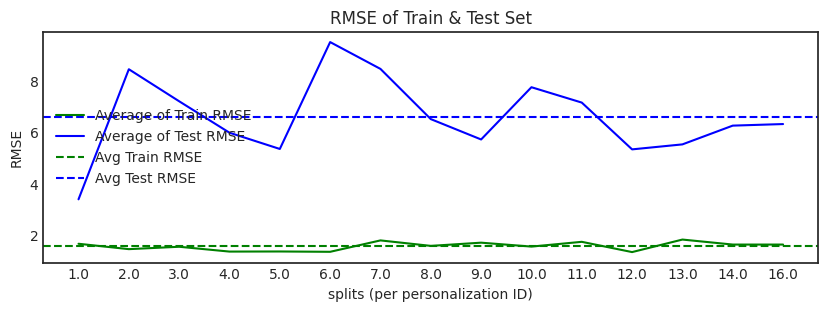

In [ ]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(eval_df['id'], eval_df['train_rmse'], 'g', label='Average of Train RMSE')
plt.plot(eval_df['id'], eval_df['test_rmse'], 'b', label='Average of Test RMSE')

# 가로 점선 추가
plt.axhline(y=avg_train_rmse, color='g', linestyle='--', label='Avg Train RMSE')
plt.axhline(y=avg_test_rmse, color='b', linestyle='--', label='Avg Test RMSE')

plt.title('RMSE of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('RMSE')
plt.legend()

In [ ]:
# Compute average of MAPE
avg_train_mape = eval_df['train_acc'].mean()
avg_test_mape = eval_df['test_acc'].mean()

In [ ]:
eval_df.head(15)

,train_rmse,test_rmse,id,train_mape,test_mape,train_acc,test_acc
0,1.658895,3.382882,1.0,0.877951,1.266182,99.122049,98.733818
1,1.449932,8.429208,2.0,0.734198,1.978518,99.265802,98.021482
2,1.542658,7.186188,3.0,0.796614,2.120503,99.203386,97.879497
3,1.355409,5.966665,4.0,0.682912,1.712549,99.317088,98.287451
4,1.359450,5.336500,5.0,0.682688,1.807428,99.317312,98.192572
5,1.346730,9.482829,6.0,0.694414,2.073591,99.305586,97.926409
6,1.788957,8.442044,7.0,0.896010,3.051573,99.103990,96.948427
7,1.576651,6.494747,8.0,0.799839,1.963459,99.200161,98.036541
8,1.701185,5.704695,9.0,0.889247,1.696731,99.110753,98.303269
9,1.549279,7.731988,10.0,0.818642,2.172459,99.181358,97.827541


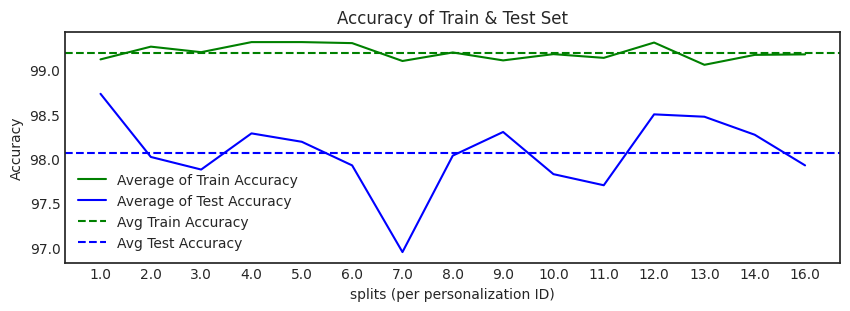

In [ ]:
# 그래프 그리기
plt.figure(figsize=(10, 3))
plt.plot(eval_df['id'], eval_df['train_acc'], 'g', label='Average of Train Accuracy')
plt.plot(eval_df['id'], eval_df['test_acc'], 'b', label='Average of Test Accuracy')

# 가로 점선 추가
plt.axhline(y=avg_train_mape, color='g', linestyle='--', label='Avg Train Accuracy')
plt.axhline(y=avg_test_mape, color='b', linestyle='--', label='Avg Test Accuracy')

plt.title('Accuracy of Train & Test Set')
plt.xlabel('splits (per personalization ID)')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
eval_df.head(20)

,train_rmse,test_rmse,id,train_mape,test_mape,train_acc,test_acc
0,1.658895,3.382882,1.0,0.877951,1.266182,99.122049,98.733818
1,1.449932,8.429208,2.0,0.734198,1.978518,99.265802,98.021482
2,1.542658,7.186188,3.0,0.796614,2.120503,99.203386,97.879497
3,1.355409,5.966665,4.0,0.682912,1.712549,99.317088,98.287451
4,1.359450,5.336500,5.0,0.682688,1.807428,99.317312,98.192572
5,1.346730,9.482829,6.0,0.694414,2.073591,99.305586,97.926409
6,1.788957,8.442044,7.0,0.896010,3.051573,99.103990,96.948427
7,1.576651,6.494747,8.0,0.799839,1.963459,99.200161,98.036541
8,1.701185,5.704695,9.0,0.889247,1.696731,99.110753,98.303269
9,1.549279,7.731988,10.0,0.818642,2.172459,99.181358,97.827541


In [ ]:
imp_err = importances.groupby('value').std(numeric_only=True).rename(columns={'importances':'std'})#.sort_values(by='importances', ascending=False)

In [ ]:
filteredimp = importances.groupby('value').mean(numeric_only=True).sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                        importances       std
value                                        
Minfrommid                 0.132828  0.015249
elapsed_minutes_intake     0.086765  0.008519
HBGI                       0.084525  0.016335
HbA1c                      0.082583  0.028014
carbs2hr                   0.079551  0.019964
PeakEDA2hr_mean            0.079143       NaN
Activity24                 0.075968  0.010355
sugar8hr                   0.073212  0.013778
ID                         0.072537  0.014280
acc_skew                   0.072214  0.016522
acc_mean_2hrs              0.071123  0.009985
LBGI                       0.070359  0.008138
acc_max_2hrs               0.068794  0.008212
J_index                    0.068343  0.010675
calories24hr               0.065364  0.008823
MAGE                       0.064308  0.006100
Biological Sex             0.063694  0.024171
eda_skew                   0.063614  0.004945
acc_std                    0.057686  0.008015
CONGA8                     0.05652

/tmp/ipykernel_3694/3888890867.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


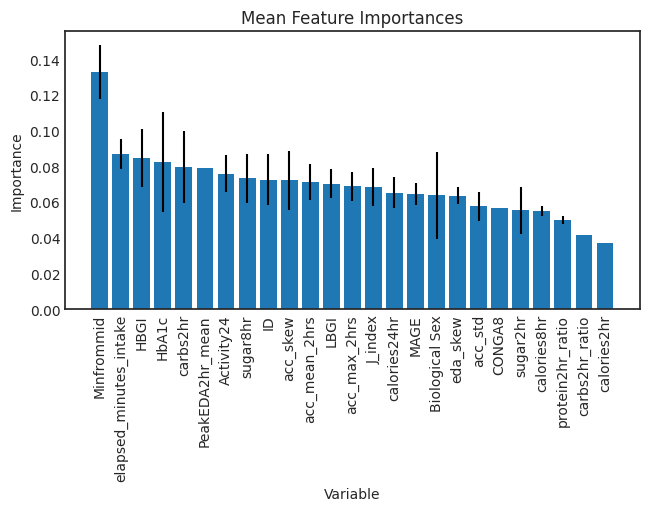

In [ ]:
plt.style.use('seaborn-white')
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical', yerr=filteredimp['std'])# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()

In [ ]:
'''
avg_test_auc_list = []
avg_train_auc_list = []

for i in range(5): # i*10 (%) for train_split
    avg_train_auc, avg_test_auc, eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = partialPersonalizationLoocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100, fs=0.02, personalization_train_percent=i*0.1)
    avg_train_auc_list.append(avg_train_auc)
    avg_test_auc_list.append(avg_test_auc)
'''

"\navg_test_auc_list = []\navg_train_auc_list = []\n\nfor i in range(5): # i*10 (%) for train_split\n    avg_train_auc, avg_test_auc, eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = partialPersonalizationLoocvRF(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime'], numestimators=100, fs=0.02, personalization_train_percent=i*0.1)\n    avg_train_auc_list.append(avg_train_auc)\n    avg_test_auc_list.append(avg_test_auc)\n"